In [25]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score

# Statistical imports
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Other imports
from ISLP import load_data
from datetime import datetime

In [26]:
# load the data
stocks = pd.read_csv('./data/dow_jones_index.data')

# find out which vars have dollar signs in their values 
dollar_sign_list = []
for col in stocks.columns:
    # Check if any value in the column contains a dollar sign
    if stocks[col].astype(str).str.contains('\$').any():
        dollar_sign_list.append(col)
        
# Kill dolar signs and turn into floats
for col in dollar_sign_list:
    stocks[col] = stocks[col].replace('[\$,]', '', regex=True).astype(float)
        
# Change dates to numeric
date_format = "%m/%d/%Y"
stocks['date'] = stocks['date'].apply(lambda x: pd.to_datetime(x, format='%m/%d/%Y'))

# set up lagged variables
stocks['lag1'] = stocks['close'].shift(1)
stocks['lag2'] = stocks['close'].shift(2)
stocks['lag3'] = stocks['close'].shift(3)
stocks['lag4'] = stocks['close'].shift(4)

# Take a four week moving avg
stocks['rolling_avg'] = stocks['close'].rolling(window=4).mean()

# can't use future variables so kill them
stocks.drop(
    [
        'next_weeks_open',
        'next_weeks_close',
        'percent_change_price',
        'percent_change_next_weeks_price'
    ], axis = 1, inplace = True)

# Variable selection

### Which Lag is Best?

<Figure size 1440x720 with 0 Axes>

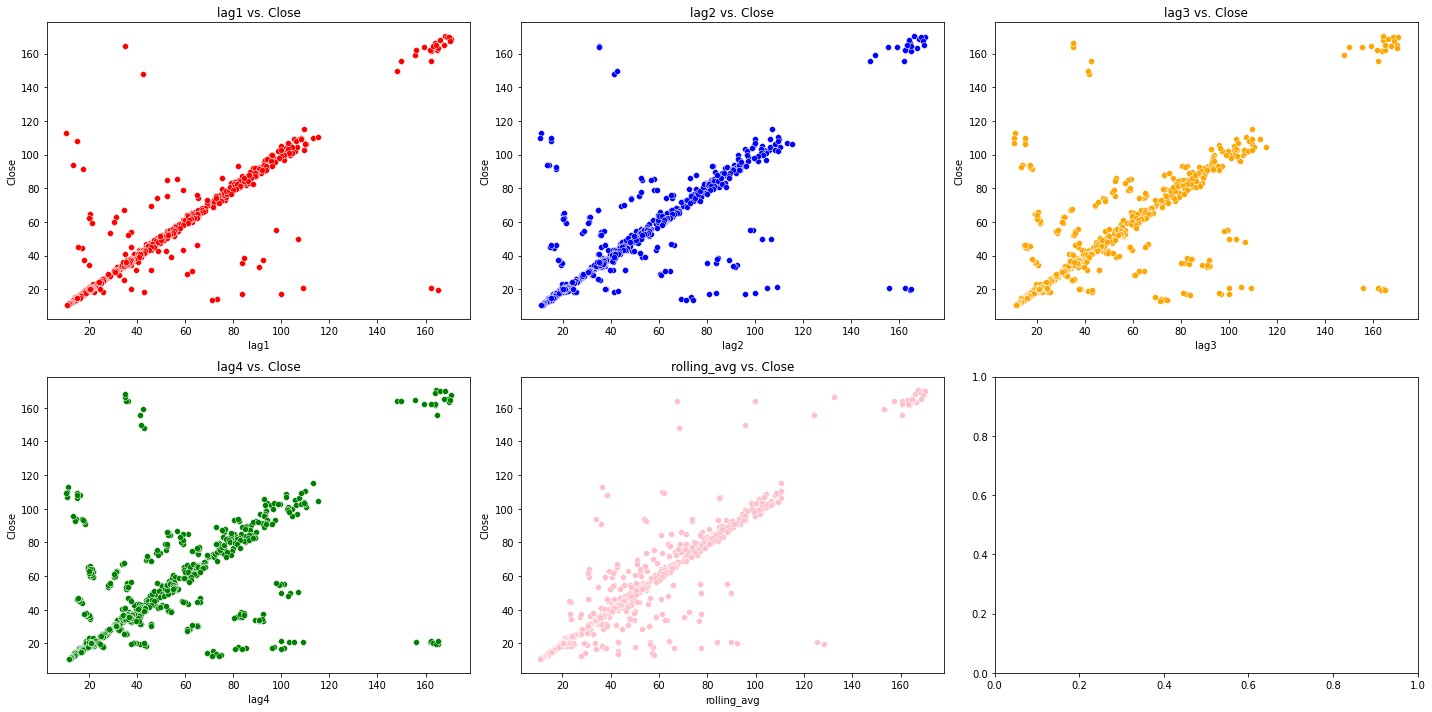

In [27]:

plt.figure(figsize=(20, 10));

colors = ['red', 'blue', 'orange', 'green','pink']
lags = ['lag1', 'lag2', 'lag3', 'lag4', 'rolling_avg']

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Flatten the array
axs = axs.flatten()

for i, (lag, color) in enumerate(zip(lags, colors)):
    # Plot on the i-th subplot
    sns.scatterplot(x=lag, y='close', data=stocks, color=color, ax=axs[i])
    axs[i].set_title(f'{lag} vs. Close')
    axs[i].set_xlabel(lag)
    axs[i].set_ylabel('Close')

plt.tight_layout()
plt.show();

In [28]:
stocks.drop(['lag2','lag3','lag4','rolling_avg'], inplace=True, axis = 1)
stocks = stocks.dropna()

train = stocks[stocks['quarter'] == 1]
test = stocks[stocks['quarter'] == 2]

y_train = train['close']
y_test = test['close']
X_train = train.drop(['stock','close', 'date'], axis = 1)
X_test = test.drop(['stock','close','date'], axis = 1)

### All other variables

In [29]:
# FIT RANDOM FOREST
# get features needed
max_features = X_train.shape[1]
tree_count   = 1000

# set up model
rf_reg = RandomForestRegressor(
    max_features=max_features,
    random_state=27,
    n_estimators=tree_count
)

# fit model
rf_reg.fit(X_train, y_train)
# make predictions
rf_preds = rf_reg.predict(X_test)
# get mse
rf_mse = mean_squared_error(y_test, rf_preds)

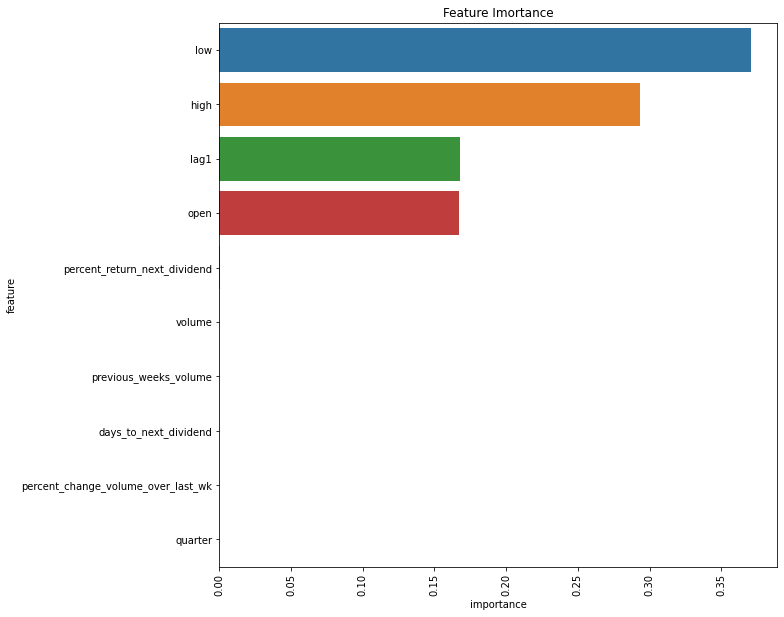

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X_train' is a pandas DataFrame and you have already defined 'rf_reg' and fit it to your data

# Create a DataFrame with feature names and their importance scores
plot_df = pd.DataFrame({
    'feature': X_train.columns,  # Use the column names from the DataFrame
    'importance': rf_reg.feature_importances_  # Feature importances from the RandomForestRegressor
})

# Plotting feature importances
plt.figure(figsize=(10, 10))
sns.barplot(x='importance', y='feature', data=plot_df.sort_values('importance', ascending=False))
plt.xticks(rotation=90)
plt.title('Feature Imortance')
plt.show()

# Modeling

### Use Cross Validation to find best SVR hyper params

In [31]:
# Define a grid of hyperparameters
param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.01, 0.1, 0.5]
}

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svr_reg = SVR()

# Perform grid search with cross-validation
grid_search = GridSearchCV(svr_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)  

# Retrieve the best parameters
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best parameters:", best_params)
print("Best estimator:", best_estimator)

Best parameters: {'C': 10.0, 'epsilon': 0.5}
Best estimator: SVR(C=10.0, epsilon=0.5)


### Make function for isolating stocks by tic

In [32]:
def return_stock(df, tic):
    df = df[df['stock'] == tic]
    df = df.drop('stock', axis=1)
    
    train = df[df['quarter'] == 1]
    test = df[df['quarter'] == 2]
    
    y_train = train['close']
    y_test = test['close']
    
    # determined from variable selection above
    X_train = train[['low','high','open','lag1']]
    X_test = test[['low','high','open','lag1']]
    
    return X_train, X_test, y_train, y_test

### Actual modeling

In [ ]:
unique_tics = stocks['stock'].unique()
results_dict = {'Tic':[],'DT_MSE':[], 'RF_MSE': [], 'LR_MSE':[], 'SVR_MSE': []}

for tic in unique_tics:
    # GET EACH STOCK INDIVIDUALLY
    X_train, X_test, y_train, y_test = return_stock(stocks, tic)
    
    # FIT DECISION TREE
    # get features needed
    max_features = X_train.shape[1]
    tree_count = 1000

    # set up model
    dc_reg = DecisionTreeRegressor(max_features=max_features, random_state=27)
    #fit mode
    dc_reg.fit(X_train, y_train)
    # make predictions
    dt_preds = dc_reg.predict(X_test)
    # get mse
    dt_mse = mean_squared_error(y_test, dt_preds)
    
    # FIT RANDOM FOREST
    # set up model
    rf_reg = RandomForestRegressor(max_features=max_features, random_state=27, n_estimators=tree_count)
    # fit model
    rf_reg.fit(X_train, y_train)
    # make predictions
    rf_preds = rf_reg.predict(X_test)
    # get mse
    rf_mse = mean_squared_error(y_test, rf_preds)
    
    # FIT LINEAR REGRESSION
    lr_reg = LinearRegression()
    lr_reg.fit(X_train, y_train)
    lr_preds = lr_reg.predict(X_test)
    lr_mse = mean_squared_error(y_test, lr_preds)
    
    # FIT SUPPORT VECTOR REGRESSION
    # scale for svr
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    svr_reg = SVR(C = best_params['C'], epsilon = best_params['epsilon']) 
    svr_reg.fit(X_train_scaled, y_train)
    svr_preds = svr_reg.predict(X_test_scaled)
    svr_mse = mean_squared_error(y_test, svr_preds)
    
    # APPEND RESULTS
    # name
    results_dict['Tic'].append(tic)
    # decesion tree
    results_dict['DT_MSE'].append(dt_mse)
    # random forest
    results_dict['RF_MSE'].append(rf_mse)
    # linear regression
    results_dict['LR_MSE'].append(lr_mse)
    # svr
    results_dict['SVR_MSE'].append(svr_mse)

# Show results

In [ ]:
df_results = pd.DataFrame(results_dict)

# Calculate the mean of the 'DT_MSE' and 'RF_MSE' columns
mean_DT_MSE = df_results['DT_MSE'].mean()
mean_RF_MSE = df_results['RF_MSE'].mean()
mean_LR_MSE = df_results['LR_MSE'].mean()
mean_SVR_MSE = df_results['SVR_MSE'].mean()


# Append a new row with these means
# Note: 'Tic' is set to 'Mean' or another placeholder to indicate this row is different
new_row = pd.DataFrame({
    'Tic': 'MEAN',
    'DT_MSE': mean_DT_MSE,
    'RF_MSE': mean_RF_MSE,
    'LR_MSE': mean_LR_MSE,
    'SVR_MSE': mean_SVR_MSE
}, index=[0])

# glue together the mean row and the full data
df_results = pd.concat([df_results, new_row], ignore_index=True)
# show to the use
df_results.tail(1)

# Risk Analysis

In [ ]:
dow = pd.read_csv('./data/DOW.csv')

In [ ]:
# load the data
dow_df = pd.read_csv('./data/DOW.csv')
dow_df.drop(0, inplace=True)


# get rid of $ signs
variables_with_comas = []

for col in dow_df.drop('Date', axis=1).columns:
    # Check if any value in the column contains a comma
    if ',' in str(dow_df[col].iloc[0]):
        dow_df[col] = dow_df[col].replace('[,]', '', regex=True).astype(float)
        

dow_df.drop(['Adj Close','Volume'], inplace = True, axis = 1)

dow_df['Date'] = dow_df['Date'].apply(lambda x: pd.to_datetime(x, format='%m/%d/%y'))

In [ ]:
# SET VARS
final_week = stocks[stocks['date'] == pd.to_datetime('2011-06-24')]

coef_dict = {
   'tic': [],
    'coef': [],
    'predicted_close': []
}

y = pd.DataFrame(dow_df['Close'])

# REFIT RANDOM FOREST WITH WHOLE DATA
y_train = train['close']
X_train = train[['low','high','open','lag1']]

# instantiate model
rf_reg = RandomForestRegressor(max_features=max_features, random_state=27, n_estimators=tree_count)
# fit model
rf_reg.fit(X_train, y_train)

for tic in unique_tics:

    X = pd.DataFrame(stocks[stocks['stock'] == tic]['close'])

    # FIT LINEAR REGRESSION
    lr_reg = LinearRegression()
    lr_reg.fit(X, y)
    
    # use best model to make final week prediction
    _, X_test, _, _ = return_stock(final_week, tic)
    final_week_pred = rf_reg.predict(X_test)
    
    # append name
    coef_dict['tic'].append(tic)
    # append linear regression coeficient
    coef_dict['coef'].append(lr_reg.coef_[0][0])
    # append predicted closing price
    coef_dict['predicted_close'].append(final_week_pred[0])

In [ ]:
df_coef = pd.DataFrame(coef_dict)
df_coef.head(3)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from adjustText import adjust_text

# Assuming df_coef is your DataFrame

plt.figure(figsize=(12, 7))
sns.scatterplot(x='coef', y='predicted_close', data=df_coef, hue = 'tic', legend=False)

texts = []
for index, row in df_coef.iterrows():
    texts.append(plt.text(row['coef'], row['predicted_close'], row['tic'], ha='right', va='bottom'))

adjust_text(
    texts,
    arrowprops=dict(arrowstyle='->', color='black')
)

plt.xlabel('Coefficient')
plt.ylabel('Predicted Close')
plt.title('Risk Assesment')
plt.show()